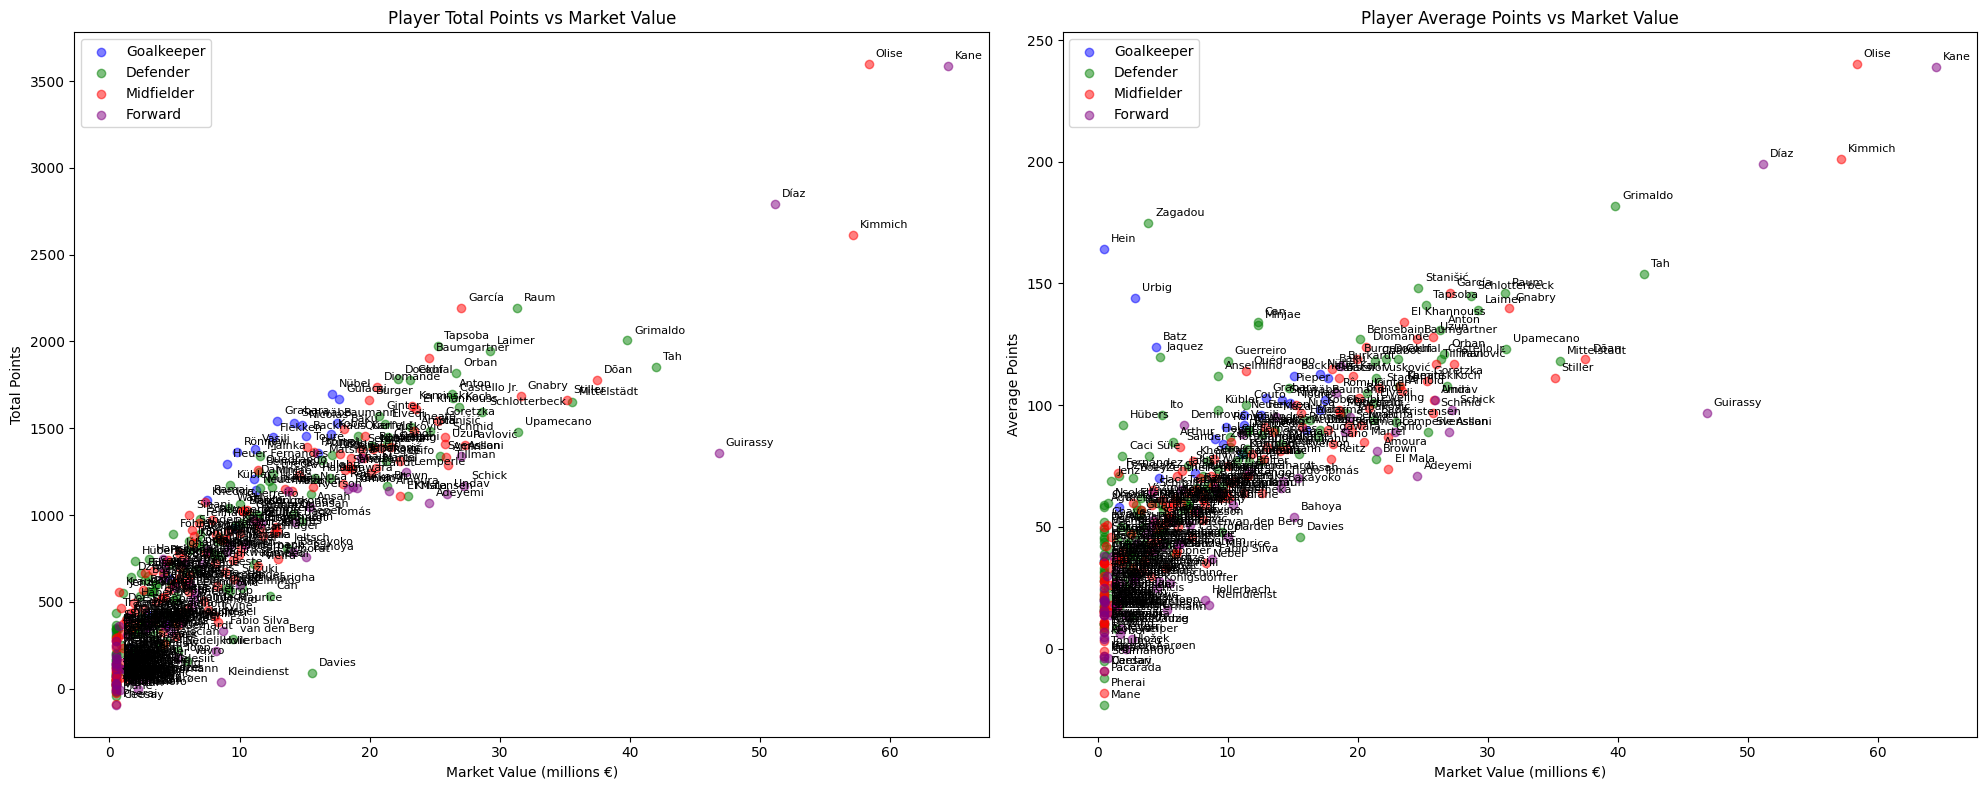

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('detailed_players.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract player data
players = data['players']

# Prepare lists for plotting
avg_points = []
total_points = []
market_values = []
names = []
positions = []

for player_id, player_info in players.items():
    # Skip players with missing data
    if 'ap' not in player_info or 'mv' not in player_info:
        continue
        
    avg_points.append(player_info['ap'])
    total_points.append(player_info.get('tp', 0))
    market_values.append(player_info['mv'] / 1000000)  # Convert to millions
    names.append(player_info['ln'])  # Last name only
    positions.append(player_info['pos'])

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Position colors and labels
colors = ['blue', 'green', 'red', 'purple']
pos_labels = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']

# 1. Market Value vs Total Points
for pos in [1, 2, 3, 4]:
    mask = [p == pos for p in positions]
    ax1.scatter([mv for i, mv in enumerate(market_values) if mask[i]], 
                [tp for i, tp in enumerate(total_points) if mask[i]], 
                alpha=0.5, label=pos_labels[pos-1], c=colors[pos-1])
    
    # Add names for players with high market value or high total points
    for i, (mv, tp, name) in enumerate(zip(market_values, total_points, names)):
        if positions[i] == pos:
            ax1.annotate(name, (mv, tp), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)

ax1.set_xlabel('Market Value (millions €)')
ax1.set_ylabel('Total Points')
ax1.set_title('Player Total Points vs Market Value')
ax1.legend()

# 2. Market Value vs Average Points
for pos in [1, 2, 3, 4]:
    mask = [p == pos for p in positions]
    ax2.scatter([mv for i, mv in enumerate(market_values) if mask[i]], 
                [ap for i, ap in enumerate(avg_points) if mask[i]], 
                alpha=0.5, label=pos_labels[pos-1], c=colors[pos-1])
    
    # Add names for players with high market value or high average points
    for i, (mv, ap, name) in enumerate(zip(market_values, avg_points, names)):
        if positions[i] == pos:
            ax2.annotate(name, (mv, ap), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)

ax2.set_xlabel('Market Value (millions €)')
ax2.set_ylabel('Average Points')
ax2.set_title('Player Average Points vs Market Value')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

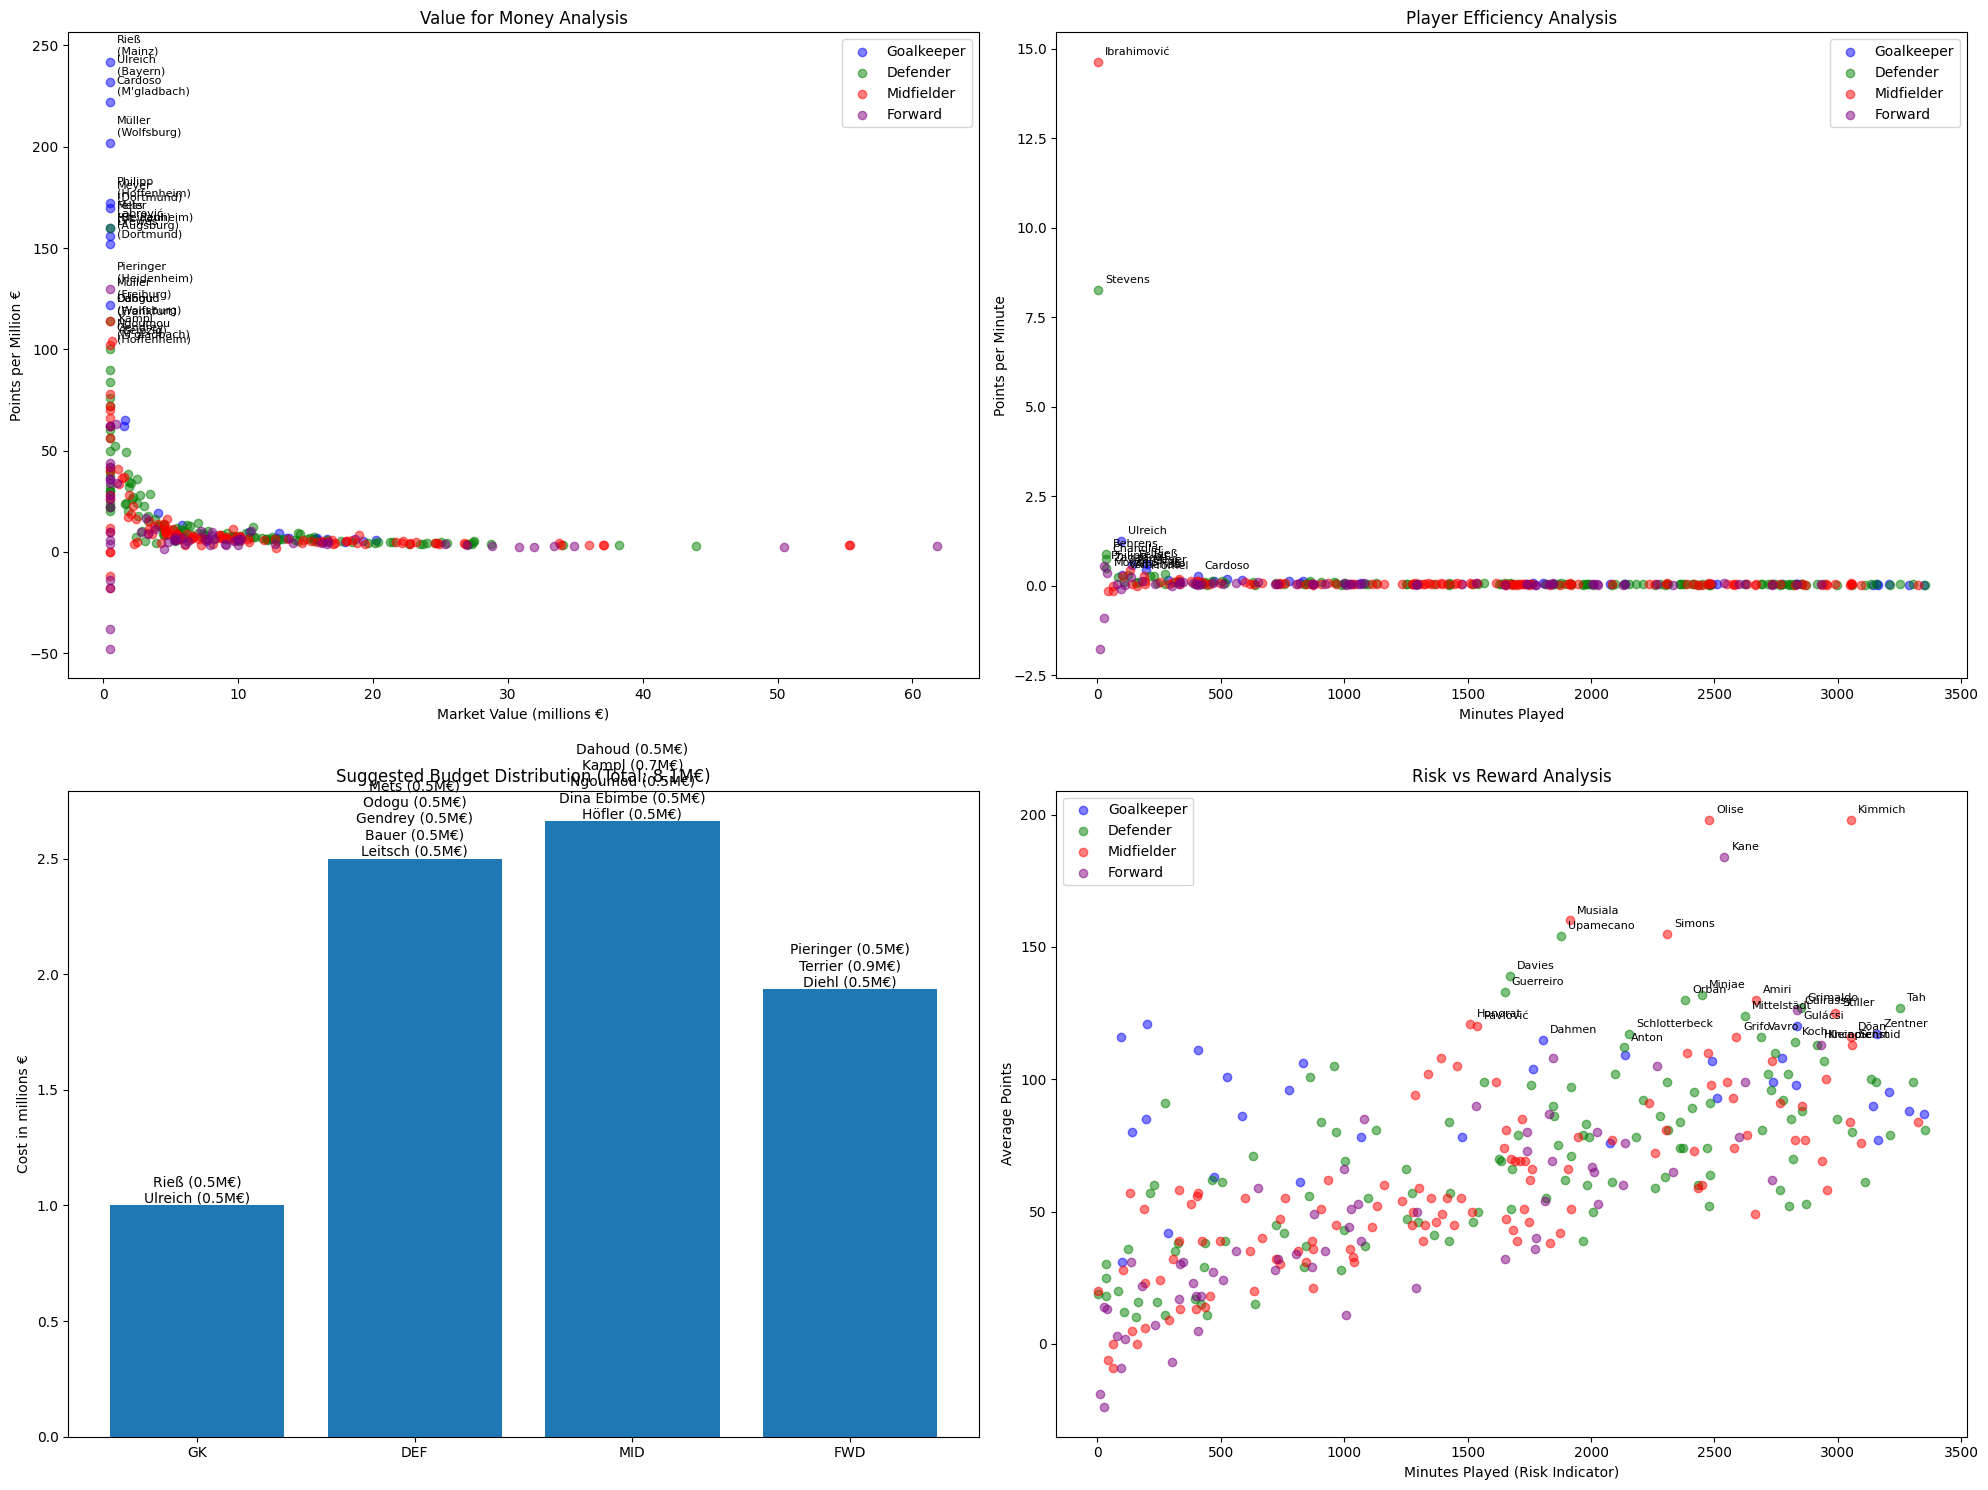

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('detailed_players.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract player data
players = data['players']

# Calculate efficiency metrics
player_stats = []
for player_id, info in players.items():
    if 'ap' not in info or 'mv' not in info:
        continue
        
    # Calculate points per million euros
    points_per_million = info['ap'] / (info['mv'] / 1000000)
    
    # Calculate points per minute played
    minutes_played = info.get('sec', 0) / 60  # Convert seconds to minutes
    points_per_minute = info['ap'] / minutes_played if minutes_played > 0 else 0
    
    player_stats.append({
        'name': info['ln'],
        'position': info['pos'],
        'market_value': info['mv'] / 1000000,
        'avg_points': info['ap'],
        'total_points': info.get('tp', 0),
        'points_per_million': points_per_million,
        'points_per_minute': points_per_minute,
        'minutes_played': minutes_played,
        'goals': info.get('g', 0),
        'assists': info.get('a', 0),
        'yellow_cards': info.get('y', 0),
        'team': info.get('tn', '')
    })

# Create figure with multiple plots
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 2)

# 1. Points per Million € (Value for Money)
ax1 = fig.add_subplot(gs[0, 0])
colors = ['blue', 'green', 'red', 'purple']
pos_labels = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']

for pos in [1, 2, 3, 4]:
    pos_players = [p for p in player_stats if p['position'] == pos]
    if pos_players:
        x = [p['market_value'] for p in pos_players]
        y = [p['points_per_million'] for p in pos_players]
        ax1.scatter(x, y, alpha=0.5, label=pos_labels[pos-1], c=colors[pos-1])
        
        # Annotate best value players
        for p in pos_players:
            if p['points_per_million'] > np.percentile([p['points_per_million'] for p in player_stats], 95):
                ax1.annotate(f"{p['name']}\n({p['team']})", 
                           (p['market_value'], p['points_per_million']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

ax1.set_xlabel('Market Value (millions €)')
ax1.set_ylabel('Points per Million €')
ax1.set_title('Value for Money Analysis')
ax1.legend()

# 2. Points per Minute (Efficiency)
ax2 = fig.add_subplot(gs[0, 1])
for pos in [1, 2, 3, 4]:
    pos_players = [p for p in player_stats if p['position'] == pos]
    if pos_players:
        x = [p['minutes_played'] for p in pos_players]
        y = [p['points_per_minute'] for p in pos_players]
        ax2.scatter(x, y, alpha=0.5, label=pos_labels[pos-1], c=colors[pos-1])
        
        # Annotate most efficient players
        for p in pos_players:
            if p['points_per_minute'] > np.percentile([p['points_per_minute'] for p in player_stats], 95):
                ax2.annotate(p['name'], 
                           (p['minutes_played'], p['points_per_minute']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

ax2.set_xlabel('Minutes Played')
ax2.set_ylabel('Points per Minute')
ax2.set_title('Player Efficiency Analysis')
ax2.legend()

# 3. Budget Distribution Suggestion
ax3 = fig.add_subplot(gs[1, 0])
budget = 150  # Example budget in millions
top_value_players = sorted(player_stats, key=lambda x: x['points_per_million'], reverse=True)

suggested_team = {1: [], 2: [], 3: [], 4: []}  # By position
total_cost = 0
required_players = {1: 2, 2: 5, 3: 5, 4: 3}  # Typical formation requirements

for player in top_value_players:
    pos = player['position']
    if len(suggested_team[pos]) < required_players[pos] and total_cost + player['market_value'] <= budget:
        suggested_team[pos].append(player)
        total_cost += player['market_value']

# Plot suggested budget distribution
positions = ['GK', 'DEF', 'MID', 'FWD']
costs = [sum(p['market_value'] for p in suggested_team[i+1]) for i in range(4)]
ax3.bar(positions, costs)
ax3.set_title(f'Suggested Budget Distribution (Total: {total_cost:.1f}M€)')
ax3.set_ylabel('Cost in millions €')

# Add player names to bars
for i, pos in enumerate(suggested_team):
    names = '\n'.join([f"{p['name']} ({p['market_value']:.1f}M€)" for p in suggested_team[pos]])
    ax3.text(i, costs[i], names, ha='center', va='bottom')

# 4. Risk Analysis (Minutes played vs Points)
ax4 = fig.add_subplot(gs[1, 1])
for pos in [1, 2, 3, 4]:
    pos_players = [p for p in player_stats if p['position'] == pos]
    if pos_players:
        x = [p['minutes_played'] for p in pos_players]
        y = [p['avg_points'] for p in pos_players]
        ax4.scatter(x, y, alpha=0.5, label=pos_labels[pos-1], c=colors[pos-1])
        
        # Annotate high-performing, low-risk players
        for p in pos_players:
            if p['avg_points'] > np.percentile([p['avg_points'] for p in player_stats], 90) and p['minutes_played'] > 500:
                ax4.annotate(p['name'], 
                           (p['minutes_played'], p['avg_points']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_xlabel('Minutes Played (Risk Indicator)')
ax4.set_ylabel('Average Points')
ax4.set_title('Risk vs Reward Analysis')
ax4.legend()

plt.tight_layout()
plt.show()

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('detailed_players.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract and calculate player stats (excluding players below 3M€)
player_stats = []
for player_id, info in players.items():
    if 'ap' not in info or 'mv' not in info:
        continue
    
    market_value_m = info['mv'] / 1000000
    # Skip players with market value below 3M€
    if market_value_m < 6:
        continue
        
    points_per_million = info['ap'] / market_value_m if market_value_m > 0 else 0
    
    player_stats.append({
        'name': f"{info.get('ln', '')}",
        'team': info.get('tn', ''),
        'position': info['pos'],
        'market_value': market_value_m,
        'avg_points': info['ap'],
        'points_per_million': points_per_million
    })

# Create figure
plt.figure(figsize=(15, 10))

# Colors and labels for positions
colors = ['blue', 'green', 'red', 'purple']
pos_labels = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']

# Scatter plot: Points per Million vs Market Value
for pos in [1, 2, 3, 4]:
    pos_players = [p for p in player_stats if p['position'] == pos]
    if pos_players:
        x = [p['market_value'] for p in pos_players]
        y = [p['points_per_million'] for p in pos_players]
        plt.scatter(x, y, alpha=0.5, label=pos_labels[pos-1], c=colors[pos-1])
        
        threshold = np.percentile([p['points_per_million'] for p in player_stats], 0)
        for p in pos_players:
            if p['points_per_million'] > threshold:
                plt.annotate(f"{p['name']}", 
                           (p['market_value'], p['points_per_million']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Market Value (millions €)')
plt.ylabel('Points per Million €')
plt.title('Value for Money Analysis (Players >3M€)')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'players' is not defined